# Nonlinearities

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import time
from tqdm import tqdm
import seaborn as sns

from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical #one hot encoding
from sklearn.datasets import make_moons, make_blobs

import torch
from torch import nn
from torchsummary import summary

(800, 2) (200, 2) (800,) (200,)


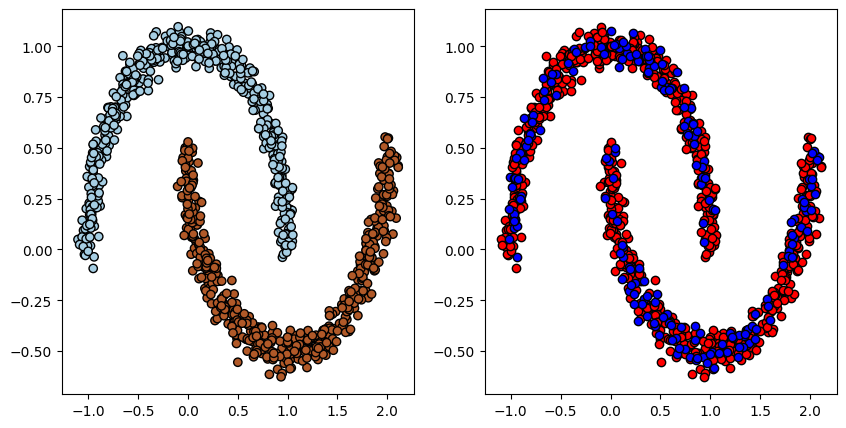

In [2]:
# Configuration options
num_classes = 2
X, y = make_moons(n_samples= 1000 , noise=0.05)
# X, y = make_blobs(n_samples=1000, n_features=2, centers=3, random_state=1)

X_train, X_test, y_train, y_test = train_test_split( X , y , test_size = 0.20, random_state = 1)
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)

_, axes = plt.subplots (1,2, figsize=(10,5))

axes[0].scatter( X[:, 0] , X[:, 1] , c = y , edgecolors='k', cmap='Paired')
axes[1].scatter( X_train[:, 0], X_train[:, 1] , c="r", edgecolors='k')
axes[1].scatter( X_test[:, 0] , X_test[:, 1] , c="b", edgecolors='k')

In [3]:
# # Convert into greyscale
# X_train = X_train.astype('float32')
# X_test = X_test.astype('float32')

In [4]:
# Convert target classes to categorical ones
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

# Set the input shape
input_shape = (X_train.shape)
print(f'Feature shape: {input_shape}')

Feature shape: (800, 2)


In [5]:
print (X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.shape, y_test.shape)
print(y_test[0:5, :])

(800, 2) (200, 2) (800, 2) (200, 2)
(800, 2) (200, 2)
[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


## Create a graph model

In [6]:
model = nn.Sequential(
    nn.Linear(in_features=2, out_features=10), nn.ReLU(),
    nn.Linear(in_features=10, out_features=num_classes)
)

# model.cuda()
summary(model, input_size=(2,), device='cpu')
# print (model)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 10]              30
              ReLU-2                   [-1, 10]               0
            Linear-3                    [-1, 2]              22
Total params: 52
Trainable params: 52
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------


## Define loss function and optimizer

In [7]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 1e-2)

# model.cuda()
# loss.cuda()

## Train model

In [8]:
epochs = 1000
batch_size = 100
losses = []

progress = tqdm(range( epochs ), ncols=100)

for epoch in progress:
  #
  batch_losses = 0

  for batch_i in range(0, len(X_train), batch_size):
    #
    batch_X = X_train[ batch_i : batch_i + batch_size ]
    batch_y = y_train[ batch_i : batch_i + batch_size ]
    batch_X = torch.from_numpy(batch_X).to(torch.float32)#.cuda()
    batch_y = torch.from_numpy(batch_y).to(torch.float32)#.cuda()

    # 1. Zero the gradients
    optimizer.zero_grad()

    # 2. Perform forward pass
    predictions = model( batch_X )

    # 3. Compute loss
    batch_loss = loss( batch_y, predictions )

    # 4. Perform backward pass
    batch_loss.backward()

    # 5. Optimize parameters
    optimizer.step()

    ## Save stats
    batch_losses += batch_loss.item()

  progress.set_description("Epoch [%d/%d] [Loss: %f]" % (epoch, epochs,batch_losses/len(X_train)/batch_size))

  losses.append(batch_losses/(len(X_train)/batch_size))


Epoch [999/1000] [Loss: 0.000003]: 100%|████████████████████████| 1000/1000 [00:18<00:00, 55.23it/s]


## Plot results

Text(0.5, 0, 'Epoch')

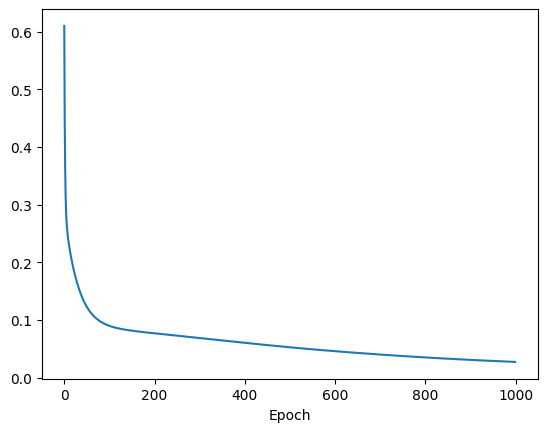

In [9]:
import seaborn as sns

plt.plot(np.array(losses))
plt.xlabel("Epoch")

In [10]:
h_min, h_max = X_test[:, 0].min()-0.2, X_test[:, 1].max()+0.2
v_min, v_max = X_test[:, 0].min()-0.1, X_test[:, 1].max()+0.1

# Crear el grid de las fronteras de decision
h_grid, v_grid = np.meshgrid(np.linspace( h_min , h_max , 300), np.linspace( v_min , v_max , 300))

# Predecir los valores del grid
grid_ = torch.from_numpy( np.c_[h_grid.ravel(), v_grid.ravel()] ).to(torch.float32)#.cuda()
pred_grid = model( grid_ )
pred_grid = np.argmax( pred_grid.detach() , axis=1)
print (pred_grid.shape)

# Encajar las predicciones al tamaño del grid
pred_grid = pred_grid.reshape(h_grid.shape)
print (pred_grid.shape)

torch.Size([90000])
torch.Size([300, 300])


[]

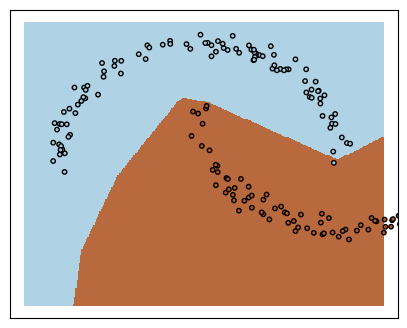

In [11]:
_, ax = plt.subplots (figsize=(5,4))

# Put the result into a color plot
ax.pcolormesh( h_grid , v_grid , pred_grid , cmap='Paired', alpha=0.9)

ax.scatter( X_test[:, 0] , X_test[:, 1] , c = np.argmax(y_test, axis=1), edgecolors='k', s=10, cmap='Paired')

ax.set_xlim(h_grid.min()-.1, h_grid.max()+.1)
ax.set_ylim(v_grid.min()-.1, v_grid.max()+.1)

ax.set_xticks(())
ax.set_yticks(())